In [ ]:
# Error with scientific format in plot axes
ENV["GKS_ENCODING"] = "utf8"

using Plots
using Printf
using Statistics

# Avoid huge svg blobs
gr(fmt="png")
nothing

```julia
using Revise
```

In [ ]:
module CliffWalking

using ReinforcementLearningSutton.Commons: Point
using ReinforcementLearningSutton.GridWorld: GameGridWorldStatic, StateGridWorldStatic, ActionGridWorldStatic, restart, state, state_set, ncols, nrows
import ReinforcementLearningSutton.GridWorld: update

struct Cliff
    track::Array{Bool, 2}
    penalty::Int
end

function update(game::GameGridWorldStatic{Cliff}, action::ActionGridWorldStatic)::Int
    cliff = game.ruleset
    s0 = state(game)
    
    pos_x = max(1, min(s0.pos.x + action.move.x, ncols(game)))
    pos_y = max(1, min(s0.pos.y + action.move.y, nrows(game)))
    penalty = ifelse(cliff.track[pos_y, pos_x], cliff.penalty, -1)
    
    if penalty < -1
        restart(game)
    else
        s = StateGridWorldStatic(nrows(game), ncols(game), Point(pos_x, pos_y))
        state_set(game, s)
    end
    penalty
end

end

┌ Info: Precompiling ReinforcementLearningSutton [6417796d-59bf-4f93-aaf0-e2be7741ea64]
└ @ Base loading.jl:1278


Main.CliffWalking

In [ ]:
using ReinforcementLearningSutton.Commons: LearningSarsa, LearningSarsaExpected, LearningQ, PlayerεGreedy, Point, play_game
using ReinforcementLearningSutton.GridWorld: GameGridWorldStaticBase, GameGridWorldStatic

In [ ]:
nrows = 4
ncols = 12
pos_start = Point(1, nrows)
pos_goal = Point(ncols, nrows)

allowed_movements = "cross"

cliff_track = zeros(Bool, nrows, ncols)
cliff_track[nrows, 2:(ncols-1)] .= true
cliff = CliffWalking.Cliff(cliff_track, -100)

game0 = GameGridWorldStaticBase(nrows, ncols, pos_start, pos_goal, allowed_movements)
game = GameGridWorldStatic(game0, cliff)
nothing

### Single parameter comparison

In [ ]:
ε = 0.1
α = 0.5
γ = 1.0

max_nsteps = 1000
ngames = 100000
nothing

#### Sarsa

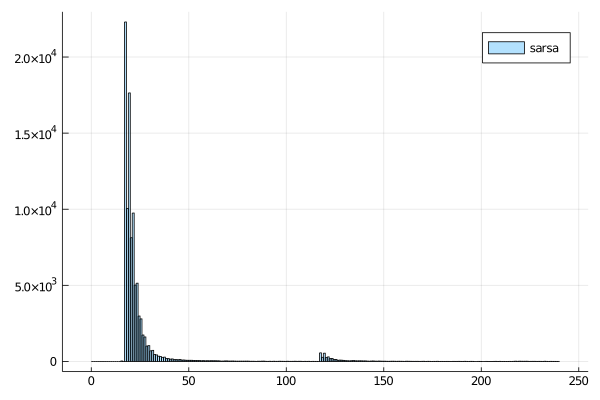

In [ ]:
player = PlayerεGreedy(game, ε)
learning = LearningSarsa(player, α, γ)

results_sarsa = -[play_game(game, player, max_nsteps, learning)[2] for _ in 1:ngames]

histogram(results_sarsa, bins=0:1:240, fillalpha=0.3, label=reshape(["sarsa"], 1, :))

In [ ]:
mean(results_sarsa)

26.91719

#### Q-learning

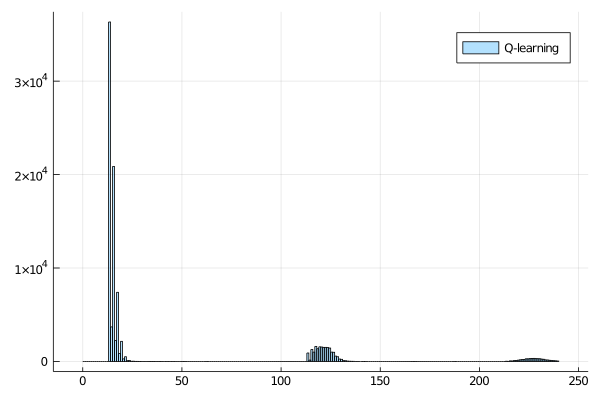

In [ ]:
player = PlayerεGreedy(game, ε)
learning = LearningQ(player, α, γ)

results_q = -[play_game(game, player, max_nsteps, learning)[2] for _ in 1:ngames]

histogram(results_q, bins=0:1:240, fillalpha=0.3, label=reshape(["Q-learning"], 1, :))

In [ ]:
mean(results_q)

50.48376

#### Expected Sarsa

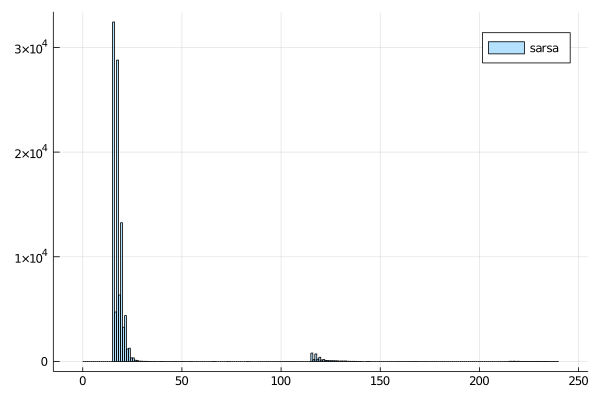

In [ ]:
player = PlayerεGreedy(game, ε)
learning = LearningSarsaExpected(player, α, γ)

results_expected_sarsa = -[play_game(game, player, max_nsteps, learning)[2] for _ in 1:ngames]

histogram(results_expected_sarsa, bins=0:1:240, fillalpha=0.3, label=reshape(["sarsa"], 1, :))

In [ ]:
mean(results_expected_sarsa)

20.7148

### Comparison of Sarsa, Q-learning and expected Sarsa

Asymptotic values:

In [ ]:
ε = 0.1
αs = 0.1:0.05:1
γ = 1.0

1.0

In [ ]:
nrounds = 10
ngames = 10000
max_nsteps = 10000

results_asymptotic = Dict{Tuple{String, Float64}, Array{Float64, 1}}()

for (learning_algo_lbl, learning_algo) in [("Sarsa", LearningSarsa),
                                           ("Q", LearningQ),
                                           ("Expected Sarsa", LearningSarsaExpected)]
    println(learning_algo_lbl)
    for α in αs
        results_asymptotic[(learning_algo_lbl, α)] = Array{Float64, 1}(undef, nrounds)
        for nround in 1:nrounds
            player = PlayerεGreedy(game, ε)
            learning = learning_algo(player, α, γ)
            outcomes = [play_game(game, player, max_nsteps, learning)[2] for _ in 1:ngames]
            results_asymptotic[(learning_algo_lbl, α)][nround] = mean(outcomes)
        end
    end
end

Sarsa
Q
Expected Sarsa


In [ ]:
nrounds = 5000
ngames = 100
max_nsteps = 10000

results = Dict{Tuple{String, Float64}, Array{Float64, 1}}()

for (learning_algo_lbl, learning_algo) in [("Sarsa", LearningSarsa),
                                           ("Q", LearningQ),
                                           ("Expected Sarsa", LearningSarsaExpected)]
    println(learning_algo_lbl)
    for α in αs
        results[(learning_algo_lbl, α)] = Array{Float64, 1}(undef, nrounds)
        for nround in 1:nrounds
            player = PlayerεGreedy(game, ε)
            learning = learning_algo(player, α, γ)
            outcomes = [play_game(game, player, max_nsteps, learning)[2] for _ in 1:ngames]
            results[(learning_algo_lbl, α)][nround] = mean(outcomes)
        end
    end
end

Sarsa
Q
Expected Sarsa


In [ ]:
results_summ = Array{Float64, 2}(undef, length(αs), 6)
for (i, learning_algo_lbl) in enumerate(["Sarsa", "Q", "Expected Sarsa"])
    for (j, α) in enumerate(αs)
        results_summ[j, i] = mean(results[(learning_algo_lbl, α)])
        results_summ[j, i + 3] = mean(results_asymptotic[(learning_algo_lbl, α)])
    end
end

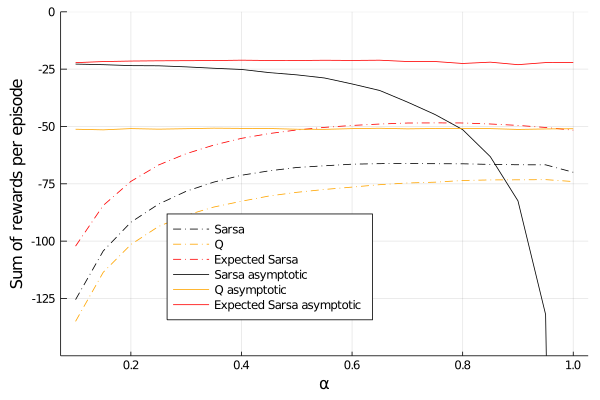

In [ ]:
plot(αs, results_summ,
     label=["Sarsa" "Q" "Expected Sarsa" "Sarsa asymptotic" "Q asymptotic" "Expected Sarsa asymptotic"],
     color = [:black :orange :red],
     linestyle = [:dashdot :dashdot :dashdot :solid :solid :solid],
     legend=:bottom,
     xlabel="α",
     ylabel="Sum of rewards per episode")
ylims!((-150, 0))

### Timing and profiling

In [ ]:
α = 0.1
learning_algo = LearningSarsa
player = PlayerεGreedy(game, ε)
learning = learning_algo(player, α, γ)
play_game(game, player, max_nsteps, learning)
@time [play_game(game, player, max_nsteps, learning) for _ in 1:1000000]
nothing

  1.275359 seconds (40.08 k allocations: 9.714 MiB)


```julia
using ProfileVega

# The default format SVG creates figures of size 9600x6400
ProfileVega.set_default_size(1200, 800)

function f(game, player, max_nsteps, learning, ngames)
    [play_game(game, player, max_nsteps, learning) for _ in 1:ngames]
end

α = 0.1
learning_algo = LearningSarsa
player = PlayerεGreedy(game, ε)
learning = learning_algo(player, α, γ)
play_game(game, player, max_nsteps, learning)
@profview f(game, player, max_nsteps, learning, 1000000)
```